# resVAE example notebook 
## Analysis of testis scRNA-Seq data

*Sören Lukassen, 08/19/19*

*updated 12/22/19*

This example notebook shows you some basic usage of resVAE on a single-cell RNA-Seq dataset of mouse testis. The dataset is from the paper [Characterization of germ cell differentiation in the male mouse through single-cell RNA sequencing](https://www.nature.com/articles/s41598-018-24725-0). In order to produce a dataset small enough to include with resVAE, we filtered it to only include early spermatocytes and condensing spermatids, and reduced the number of genes to only include those expressed in at least 10 cells, with a minimum of 100 counts total.

### 1. Imports, loading and preprocessing of data

We first need to import some dependencies, most of which are already included in resVAE itself.

In [1]:
import os
import numpy as np
import pandas as pd
from resVAE.resvae import resVAE
import resVAE.utils as cutils
from resVAE.config import config
import resVAE.reporting as report

from matplotlib import pyplot as plt
import seaborn as sns
import os


Using TensorFlow backend.


Some utility functions make loading the data easier. In this example, we use the data shipped ith resVAE in the data/ folder. The function `load_exprs` from the resVAE utils can handle data that is stored as delimited file (the delimiter can be specified by setting `sep`). In our case, the data is in a *cell by gene* format, so `order` is set to `cg`, otherwise, `gc`needs to be specified. The output is a raw count matrix and a list of gene names (row or column identifiers, depnding on the format of the input data). The data is then normalized to unit norm.
The clusters are in a densely encoded file, which we load using pandas. In order to arrive at the required one-hot or pseudo-one-hot format, we call the utility function `one_hot_encoder` from resVAE utils. You can of course also do the encoding yourself if you want. If you choose to stick to our encoder, which is mostly a wrapper for `keras.to_categorical` and `sklearn.preprocessing.Label_encoder`, the encoder will be returned so you can later map back latent space dimensions to classes.
Furthermore, we take the opportunity to set some parameters in the config file. Note that specifying `INPUT_SIZE` is required at the moment. The other parameters are optional, and you can play around with them. 

In [2]:
raw_counts, genes = cutils.load_exprs(path='data/exprs_mat.csv', order='cg')
norm_counts, normalizer = cutils.normalize_count_matrix(raw_counts)
clusters = pd.read_csv('data/clusters.csv', header=0)
categorical_clusters, l_encoder = cutils.one_hot_encoder(clusters['Cluster'])
config['INPUT_SHAPE'] = (raw_counts.shape[1], categorical_clusters.shape[1])
config['DECODER_REGULARIZER'] = 'var_l1_l2'
config['DECODER_REGULARIZER_INITIAL'] = 1e-6
config['LATENT_SCALE'] = 3
config['DECODER_RELU_THRESH'] = 0

### 2. Model initialization and training

We are now ready to initialize and train the model. For the initialization, we need to pass a dictionary with the config parameters. In this case the config is obtained by importing it from the corresponding resVAE module, but you can also generate it yourself. In that case, you should still use the config here as a template to make sure you are not missing any important items.

In [3]:
my_resvae = resVAE(model_dir = 'data/models', config=config)
my_resvae.genes = genes

We can now add the labels for the latent variable space:

In [4]:
my_resvae.describe_model('encoder')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 6885)         0                                            
__________________________________________________________________________________________________
Dense1 (Dense)                  (None, 512)          3525632     Input[0][0]                      
__________________________________________________________________________________________________
Dropout1 (Dropout)              (None, 512)          0           Dense1[0][0]                     
__________________________________________________________________________________________________
Dense2 (Dense)                  (None, 256)          131328      Dropout1[0][0]                   
__________________________________________________________________________________________________
Category_i

In [5]:
my_resvae.add_latent_labels(l_encoder.classes_)

As with any keras model, the resVAE model needs to be compiled. If you set the `MULTI_GPU` option in the config to some integer higher than 1 or to True, resVAE will run in multi-GPU mode (provided of course that you have multiple GPUs available). Note that this is currently experimental.

In [6]:
my_resvae.compile()

We can now fit the data, specifying the normalized expression matrix, one-hot encoded class array, and a directory to write log files into. Depending on your machine, this should take take between half a minute and maybe 5 minutes (assuming that no GPU is available). For real datasets, which are likely much larger, you should definitely consider switching to a machine with a CUDA capable GPU.

In [7]:
%%time
my_resvae.fit(exprs=norm_counts, classes=categorical_clusters, model_dir='data/models')

Train on 524 samples, validate on 132 samples
Epoch 1/300
524/524 [==============================] - 2s 3ms/step - loss: 181.4230 - val_loss: 173.1759
Epoch 2/300
524/524 [==============================] - 1s 1ms/step - loss: 136.7248 - val_loss: 123.8207
Epoch 3/300
524/524 [==============================] - 1s 1ms/step - loss: 106.9029 - val_loss: 80.5517
Epoch 4/300
524/524 [==============================] - 1s 1ms/step - loss: 54.1962 - val_loss: 22.0148
Epoch 5/300
524/524 [==============================] - 1s 1ms/step - loss: 7.0854 - val_loss: 3.1487
Epoch 6/300
524/524 [==============================] - 1s 1ms/step - loss: 6.1789 - val_loss: 3.0600
Epoch 7/300
524/524 [==============================] - 1s 1ms/step - loss: 1.0162 - val_loss: 0.6172
Epoch 8/300
524/524 [==============================] - 1s 1ms/step - loss: 1.0704 - val_loss: 0.6281
Epoch 9/300
524/524 [==============================] - 1s 1ms/step - loss: 0.2983 - val_loss: 0.1592
Epoch 10/300
524/524 [==========

(<keras.callbacks.History at 0x1128141d0>, {'fpc_real': 0.02738784867607344})

After training, we can save the model architecture and weights to restore them at a later time point.

In [8]:
my_resvae.save_model_new('data/models/')

Restoring a model is possible via the following command. **Note that a model named my_resvae must have been constructed for this to work.**

In [9]:
my_resvae.load_model_new(model_dir='data/models/', model_name='my_model')

### 3. Extracting gene mappings

This is where we get to the real applications of resVAE. For the sake of demonstrations, all thinkable types of weight mapping extractions are shown in the cell below:

Command |Meaning
--- |---
`get_latent_to_gene()` | This extracts mappings from the latent space (i.e. cell types) to genes.
`get_neuron_to_gene()` | Extract the mappings from decoder layers (gene sets) to genes. `initial_layer` indicates the index of the hidden layer, lower is closer to the latent space.
`get_latent_to_neuron()` | These are the mappings from the latent space to the decoder layers (gene sets). `target_layer` indicates the index of the hidden layer, lower is closer to the latent space.
`get_gene_biases()` | Extract the static component of gene expression.

Note that all commands either have the option `normalized` or `relative`. If this is set to true, normalized instead of raw values are returned. This may be useful in case of very strongly expressed genes overshadowing everything else (recall that we normalized by cell, but not by gene for the input!).

In [10]:
weights_clusters = my_resvae.get_latent_to_gene(normalized=True)
weights_neurons_1 = my_resvae.get_neuron_to_gene(normalized=True, initial_layer=1)
weights_neurons_2 = my_resvae.get_neuron_to_gene(normalized=False, initial_layer=2)
weights_latent_neurons_1 = my_resvae.get_latent_to_neuron(normalized=True, target_layer=1)
weights_latent_neurons_2 = my_resvae.get_latent_to_neuron(normalized=True, target_layer=2)
biases = my_resvae.get_gene_biases(relative=True)

Before we proceed, let's check the exact mapping of cell types in the latent space:

In [11]:
print(l_encoder.classes_)
print(my_resvae.classes)

['CS' 'SC1']
['CS_0', 'CS_1', 'CS_2', 'SC1_0', 'SC1_1', 'SC1_2']


So the lower indices of our latent space (0, 1, and 2) correspond to condensing spermatids, whereas the higher three encode the early spermatocytes. The number three arises from the scaling of the latent variable space, which we set earlier.
Generating a clustered heatmap of weight mappings nicely reflects this division:

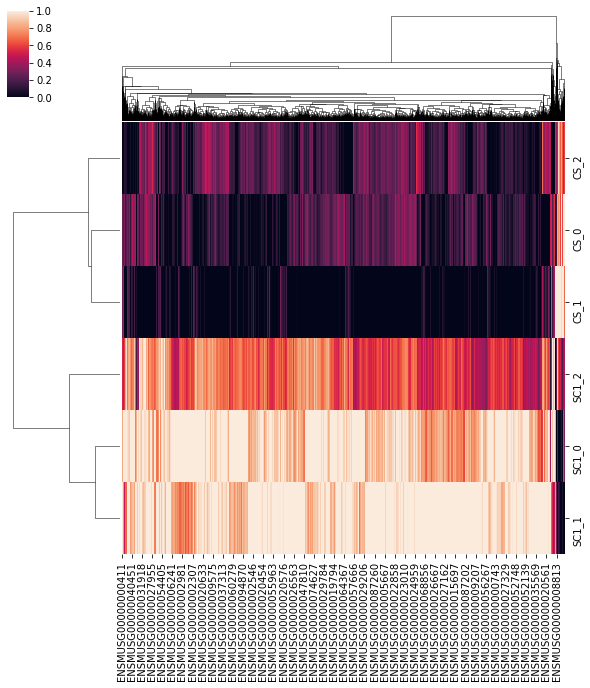

In [12]:
sns.clustermap(weights_clusters, row_cluster=True, standard_scale=1)

We would like to have a look at the genes that drive the bulk of the weight mapping, and choose an appropriate cutoff. resVAE provides a function, `calculate_elbow`, for the identification of the cutoof points, which we can visualize on a sorted representation of the weight mappings.

Text(0, 0.5, 'Weight')

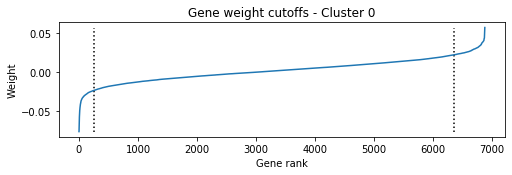

In [13]:
weights = weights_clusters
cluster = 0
pos_cutoff = cutils.calculate_elbow(weights.iloc[cluster, :])
neg_cutoff = cutils.calculate_elbow(weights.iloc[cluster, :], negative=True)
plt.figure(figsize=(8, 3))
plt.gcf().subplots_adjust(bottom=0.35)
plt.plot(np.sort(weights.iloc[cluster, :]))
plt.vlines([pos_cutoff, neg_cutoff],
            ymin=np.min(weights.iloc[cluster, :]),
            ymax=np.max(weights.iloc[cluster, :]),
            linestyles='dotted')
plt.title('Gene weight cutoffs - Cluster '+str(cluster))
plt.xlabel('Gene rank')
plt.ylabel('Weight')

Of course we are not just interested in how many genes we find, but also in what they are. We can extract the genes using the following code snippet:

In [14]:
for gene in weights.iloc[cluster,np.argsort(weights.iloc[cluster,:])].index[pos_cutoff:]:
    print(gene)

ENSMUSG00000030588
ENSMUSG00000099474
ENSMUSG00000027602
ENSMUSG00000069631
ENSMUSG00000037710
ENSMUSG00000031509
ENSMUSG00000029384
ENSMUSG00000016510
ENSMUSG00000068823
ENSMUSG00000058503
ENSMUSG00000045078
ENSMUSG00000034303
ENSMUSG00000053329
ENSMUSG00000024989
ENSMUSG00000023010
ENSMUSG00000112026
ENSMUSG00000047417
ENSMUSG00000105881
ENSMUSG00000027598
ENSMUSG00000062075
ENSMUSG00000034042
ENSMUSG00000023505
ENSMUSG00000024576
ENSMUSG00000024695
ENSMUSG00000021282
ENSMUSG00000021737
ENSMUSG00000044770
ENSMUSG00000048400
ENSMUSG00000074030
ENSMUSG00000035203
ENSMUSG00000024480
ENSMUSG00000026571
ENSMUSG00000079619
ENSMUSG00000022421
ENSMUSG00000109274
ENSMUSG00000029577
ENSMUSG00000035085
ENSMUSG00000005470
ENSMUSG00000059734
ENSMUSG00000042111
ENSMUSG00000030671
ENSMUSG00000101912
ENSMUSG00000040163
ENSMUSG00000026864
ENSMUSG00000037563
ENSMUSG00000038520
ENSMUSG00000026790
ENSMUSG00000037621
ENSMUSG00000038379
ENSMUSG00000029221
ENSMUSG00000028141
ENSMUSG00000032058
ENSMUSG00000

The top genes can be found at the bottom of this list. As resVAE is not deterministic, the results may vary slightly, but you should be able to see three transcripts among the top ranked ones, similar to this list: ENSMUSG00000026182 is *Tnp1*, ENSMUSG00000022501 is *Prm1*, and ENSMUSG00000043050 is *Tnp2*. This is a great result, as the TNP proteins are responsible for the histone to protamine exchange, the defining process of this cell type!

In [15]:
genes[np.argsort(biases)][::-1][:3]

Index(['ENSMUSG00000055762', 'ENSMUSG00000041629', 'ENSMUSG00000003970'], dtype='object')

The exact ordering here varies, but you should definitely see some genes with high scores that have housekeeping functions.

### 4. Further applications

#### *De novo* gene set identification
The commands shown above should be enough to get you started. To identify gene sets, you can extract them in the same manner as shown directly above, using the neuron-to-gene mappings rather than the latent-to-gene mappings. Once you have identified an interesting gene set, you can check for it's activation in certain cell types by identifying the latent variable space neurons that it is activated by, by calling `get_latent_to_neuron`.

#### Co-variate isolation
If you want to isolate gene sets that are strongly associated with batch effects, or you have multiple different overlapping classes that may all contribute to your samples biology, you can choose to alter your latent variable space architecture to reflect this. In case of cell type and batch, it's as easy as generating two one-hot encoded cluster arrays, one for cell type and one for batch effect, and concatenating them.

#### Softclustering
So far we only used one-hot encoding (or concatenated one-hot in case of batch effect correction). If your sample doesn't lend itself very well to hard clustering, you can also pass a matrix of partial cell identities or softclustering values to the model. Depending on the mixture percentages and the value that your clusters sum to, you may have to adjust the `LATENT_OFFSET` parameter. In general, your lowest non-zero partial cluster value times the latent offset should be at least five.

#### Cell doublets
If you should ever find yourself in a situation where you need to deal with cell types that you can't separate, resVAE can still help you identify specific pathways if you at least know the identity of the contaminating cell type and have some pure samples of these cells. Alternatively, different combinations of doublets of different cell types may also do in your case. In these cases, you can just assign the doublets the identity of both cell types setting the entry of each class in the class matrix to one.